# OLS via Gradient Descent and Matrix Inversion
Julian Hsu
2-Sept-2024

Compare performance of gradient descent and matrix inversion. To make this fair, when we use gradient descent, let's pretend we do not know the analytical form of the gradient.

**Blurb** 𝐇𝐨𝐰 𝐬𝐡𝐨𝐮𝐥𝐝 𝐰𝐞 𝐞𝐬𝐭𝐢𝐦𝐚𝐭𝐞 𝐨𝐫𝐝𝐢𝐧𝐚𝐫𝐲 𝐥𝐞𝐚𝐬𝐭 𝐬𝐪𝐮𝐚𝐫𝐞𝐬 (𝐎𝐋𝐒) 𝐦𝐨𝐝𝐞𝐥𝐬?



OLS is a verastile tool used in data science due to its relatively fast computation and easy interpretability. There are many methods for estimating OLS. Here are two common ones I see:

1. Matrix Inversion 📈- commonly featured in econometrics courses, where we derive the analytical solution for OLS so we can estimate it one calculation; and

2. Gradient Descent ⛰️- commonly featured in ML courses, where we use optimization techniques to estimate the parameters over many iterative calculations.

Below I show how accurate these methods are at estimating OLS with simulated data. Matrix Inversion and Gradient Descent have similar performance estimating the intercept term, but Matrix Inversion out-performs Gradient Descent estimating the slope term.

✍️ There are gains from "doing the math." In an era of fast computing, it is alluring to use a lot of computational resources to estimate models without having a deep understanding of how they work. However "doing the math" to understand the problem can unlock insights that will speed up your process on net.

💡Of course, this doesn't mean we should throw Gradient Descent out the window. It unlocks the ability to estimate other ML models we cannot estimate with Matrix Inversion, such as LASSO regression.



#statistics #machinelearning #causalinference

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt


In [346]:
def gradient_funct(f=None, x=None, e=0.0001):
    numerator = f(x+e)-f(x)
    return numerator/(e)

def rmse2_gradient(x=None,y=None,params=None,e=0.00000000001):
    gradient=[]
    for p in range(len(params)):        
        add_mod = np.zeros(len(params))
        add_mod[p]=e
        rmse2_push=np.mean( (np.dot(x.T,params+add_mod) - y)**2 )
        rmse2_base=np.mean( (np.dot(x.T,params) - y)**2 )
        numerator = rmse2_push - rmse2_base
        gr = float(numerator)/ float(e)                
        gradient.append( gr )
    return np.array(gradient)

def ols_gradient_descent(X, y, N, theta, learn_rate, num_iters
                        ,tolerance): 
    x = np.concatenate( (np.ones((N,1)).T, X.T ) )
    theta_history = [theta]
    
    for i in range(num_iters):
        ols_grad = rmse2_gradient(x,y,theta_history[-1])      
        change_vector = learn_rate* ols_grad
        theta_history.append( theta - change_vector ) 
        change = np.min( np.abs(change_vector) )
        if change < tolerance:
#             print('@ iteration {0} tolerance of {1} met'.format(i,tolerance))
#             print('change vector was {0}'.format(change_vector))
#             print('last gradient @ {0} was {1}'.format(theta, ols_grad))
            break
        else:
            theta = theta - change_vector
    
    return theta

def ols_matrix(X,y, N):
    x = np.concatenate( (np.ones((N,1)).T, X.T ) )
    var = np.linalg.inv( np.dot(x, x.T) )
    cov =  np.dot(y, x.T)
    beta = np.dot(cov, var)
    return beta

gt_intercept = 0.5
gt_coef = 1

def create_data(N,K):
    X = np.random.normal(0,0.5, (N, K) )
    y = gt_intercept + np.dot( np.ones(K)*gt_coef, X.T)
    y += np.random.normal(0,0.5,N)
    return X, y

In [347]:
# ## test the derivative
# ## Sample Data and runs
# N = 100
# K = 1
# X, y = create_data(N,K)

# def mse(x,y,params):
#     return np.mean( (np.dot(x.T,params) - y)**2 )

# x = np.concatenate( (np.ones((N,1)).T, X.T ) )
# plot_values = np.arange(-1,3,0.1)
# plt.scatter(x = plot_values
#            ,y = [ rmse2_gradient(x=x,y=y,params=[0.5,o],e=0.00000000001)[1] for o in plot_values] )
# plt.scatter(x = plot_values
#            ,y = [ mse(x=x,y=y,params=[0.5,o]) for o in plot_values] )


In [348]:
## Test the code
## Sample Data and runs
N = 1000
K = 1
X, y = create_data(N,K)
theta = np.zeros(K+1)
learn_rate = 0.02
num_iters = 10000
print('\nGradient Descent')
beta_g = ols_gradient_descent(X, y, N, theta
                              , learn_rate, num_iters, 0.00000001)
print(' result: {0}'.format(beta_g))


print('\nMatrix Inversion')
beta_m = ols_matrix(X,y,N)
print(' result: {0}'.format(beta_m))



Gradient Descent
 result: [0.49375293 1.01529751]

Matrix Inversion
 result: [0.49373683 1.01748204]


Simulation strategy.

For a specific dataset, collect results from different learning rates and tolerances. 

In [380]:

learn_rate_list = [0.01, 0.05, 0.1, 0.5]
sim_iters = 100

dict_results = {'ols_b0':[], 'ols_b1':[]}
for l in learn_rate_list:
    dict_results['gd_b0_{0:2.2f}'.format(l)] = []
    dict_results['gd_b1_{0:2.2f}'.format(l)] = []

    
for s in range(sim_iters):
    N = 5000
    K = 1
    X, y = create_data(N,K)

    ols_b0, ols_b1 = ols_matrix(X,y,N)
    dict_results['ols_b0'].append(ols_b0)
    dict_results['ols_b1'].append(ols_b1)

    theta = np.zeros(K+1)
    num_iters = 50000

    for learn_rate in learn_rate_list:
        gd_b0, gd_b1 = ols_gradient_descent(X, y, N, theta
                                      , learn_rate, num_iters, 0.0000000001)
        dict_results['gd_b0_{0:2.2f}'.format(learn_rate)].append(gd_b0)
        dict_results['gd_b1_{0:2.2f}'.format(learn_rate)].append(gd_b1)





In [381]:
df_results = pd.DataFrame(data=dict_results)

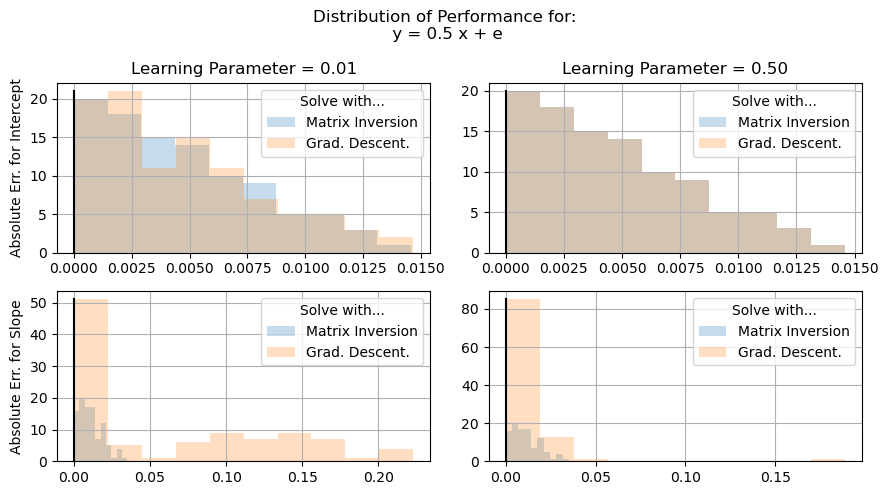

In [387]:
df_results = pd.DataFrame(data=dict_results)
plot_list = [0.01, 0.5]
fig,ax = plt.subplots(ncols=2,nrows=len(plot_list),figsize=(9,5), sharex=False)
for l in enumerate(plot_list):
    eo=ax[0,l[0]].hist( np.abs( df_results['ols_b0'] - gt_intercept) , alpha=0.25, label='Matrix Inversion') 
    lq=ax[0,l[0]].hist( np.abs( df_results['gd_b0_{0:2.2f}'.format(l[1])] - gt_intercept) , alpha=0.25, label='Grad. Descent.')     
    ax[0,l[0]].plot( [0,0], [0, np.max([ eo[0], lq[0]]) ], color='black')
#     ax[0,l[0]].set_title('Err. Dist. for Learning Parameter = {0:2.2f}'.format(l[1]))

    ax[0,l[0]].grid()
    ax[0,l[0]].legend(title='Solve with...')

    eo=ax[1,l[0]].hist( np.abs( df_results['ols_b1'] - gt_coef) , alpha=0.25, label='Matrix Inversion') 
    lq=ax[1,l[0]].hist( np.abs( df_results['gd_b1_{0:2.2f}'.format(l[1])] - gt_coef) , alpha=0.25, label='Grad. Descent.')     
    ax[1,l[0]].plot( [0,0], [0, np.max([ eo[0], lq[0]]) ], color='black')
    
    
    ax[1,l[0]].grid()
    ax[1,l[0]].legend(title='Solve with...')
    
    if l[0]==0:
        ax[0,l[0]].set_ylabel('Absolute Err. for Intercept'.format(l[1]))   
        ax[1,l[0]].set_ylabel('Absolute Err. for Slope'.format(l[1]))
    ax[0,l[0]].set_title('Learning Parameter = {0:2.2f}'.format(l[1]))

fig.suptitle('Distribution of Performance for:\n y = 0.5 x + e')
plt.tight_layout()
plt.show()



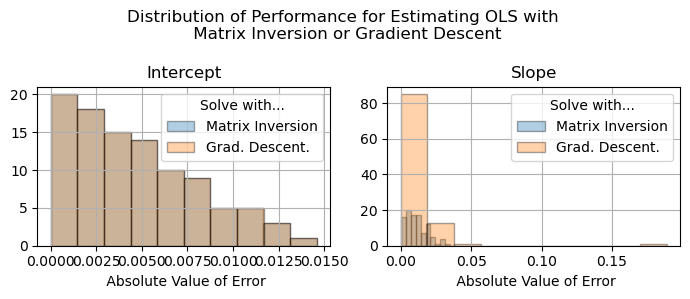

In [418]:


df_results = pd.DataFrame(data=dict_results)
plot_list = [0.01, 0.5]
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(7,3), sharex=False)
l = 0.5

eo=ax[0].hist( np.abs( df_results['ols_b0'] - gt_intercept) , edgecolor='black', alpha=0.35, label='Matrix Inversion')
lq=ax[0].hist( np.abs( df_results['gd_b0_{0:2.2f}'.format(l)] - gt_intercept) , edgecolor='black', alpha=0.35, label='Grad. Descent.')     
# ax[0].plot( [0,0], [0, np.max([ eo[0], lq[0]]) ], color='black')

ax[0].grid()
ax[0].legend(title='Solve with...')

eo=ax[1].hist( np.abs( df_results['ols_b1'] - gt_coef) , edgecolor='black', alpha=0.35, label='Matrix Inversion') 
lq=ax[1].hist( np.abs( df_results['gd_b1_{0:2.2f}'.format(l)] - gt_coef) , edgecolor='black', alpha=0.35, label='Grad. Descent.')     
# ax[1].plot( [0,0], [0, np.max([ eo[0], lq[0]]) ], color='black')


ax[1].grid()
ax[1].legend(title='Solve with...')

ax[0].set_title('Intercept'.format(l))   
ax[1].set_title('Slope'.format(l))
ax[0].set_xlabel(' Absolute Value of Error' )
ax[1].set_xlabel(' Absolute Value of Error' )

fig.suptitle('Distribution of Performance for Estimating OLS with \n Matrix Inversion or Gradient Descent')
plt.tight_layout()
plt.show()





